In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
import py3Dmol
import math
import numpy as np
import os
import pandas as pd
import glob
import re


In [2]:
def xyz_to_array(xyz_file):
    #oth index is num atoms
    #ith index is ith atom ID
    with open(xyz_file, 'r', encoding= 'utf-8') as file:
        lines = file.readlines()

    num_atoms = int(lines[0].strip())
    coordinates = []
    coordinates.append(num_atoms)

    for line in lines[2:]:
        parts = line.split()
        x, y, z = map(float, parts[1:4])
        coordinates.append([x, y, z])
    return coordinates

def sort_files(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', os.path.basename(s))]



class Peptide:

    peptide_registry ={} # each peptide will store itself in the library

    def __init__(self, smiles_code, PercentCyclization, name, csv_of_properties):
        self.molecule = Chem.AddHs(Chem.MolFromSmiles(smiles_code))
        AllChem.EmbedMolecule(self.molecule)
        self.atom_IDs = [atom.GetIdx() for atom in self.molecule.GetAtoms()]
        self.conformers = []
        self.amideGroups = []
        self.PercentCyclization = PercentCyclization
        self.Name = name
        self.properties = pd.read_csv(csv_of_properties).to_dict(orient="records")
        Peptide.peptide_registry[name] = self #the key is the name, the oobject is the peptide itself
        
    def getProperties(self):
        return self.properties

    def getName(self):
        return self.Name

    def getPercentCyclization(self):
        return self.PercentCyclization

    def csearch(self):
        pass # = Conformer(self, xyz)

    def addConformer(self, conformer):
        self.conformers.append(conformer)

    def getConformers(self):
        return self.conformers

    def addAmides(self):
        self.amideGroups = []
        group = Chem.MolFromSmarts('[C](=[O])-[N]')
        matches = self.molecule.GetSubstructMatches(group)
        if len(matches) == 0:
            return "There are no amide groups in this peptide."
        else:
            for i, IDs in enumerate(matches):
                self.amideGroups.append(AmideGroup(IDs,i,self))
            return "Added " + str(len(matches)) + " Amide groups to GroupIDs."


class Conformer(Peptide):
    def __init__(self, parent_peptide: Peptide, xyz_file, relative_energy):
        self.atom_coordinates = xyz_to_array(xyz_file)
        self.relative_energy = relative_energy
        self.parent_peptide = parent_peptide

    def getAmideDistances(self):
        distance_matrix = [[0.0 for _ in range(len(self.parent_peptide.amideGroups))] for _ in range(len(self.parent_peptide.amideGroups))]
        for i,amid1 in enumerate(self.parent_peptide.amideGroups):
            for j,amid2 in enumerate(self.parent_peptide.amideGroups):
                if i == j:
                    distance_matrix[i][j] = 0.0
                else:
                    amid1H = amid1.getH()
                    if amid1H is None:
                        distance_matrix[i][j] = -999999
                    else:
                        amid2O = amid2.getO()
                        amid1H_pos = self.atom_coordinates[amid1H]
                        amid2O_pos = self.atom_coordinates[amid2O]
                        distance = ((amid1H_pos[0] - amid2O_pos[0])**2 + (amid1H_pos[1] - amid2O_pos[1])**2 + (amid1H_pos[2] - amid2O_pos[2])**2)**0.5
                        distance_matrix[i][j] = distance
        return distance_matrix




class AmideGroup:

    def __init__(self, atom_IDs, group_num, Peptide):
        self.group_num = group_num
        self.atom_IDs = atom_IDs
        self.C = self.atom_IDs[0]
        self.O = self.atom_IDs[1]
        self.N = self.atom_IDs[2]

        nitrogen = Peptide.molecule.GetAtomWithIdx(self.N)
        neighbors = nitrogen.GetNeighbors()
        hydrogen_id = None

        for neighbor in neighbors:
            if neighbor.GetSymbol() == 'H':
                hydrogen_id = neighbor.GetIdx()
                break
        self.H = hydrogen_id


    def getIDs(self):
        return self.atom_IDs
    def getC(self):
        return self.C
    def getO(self):
        return self.O
    def getN(self):
        return self.N
    def getH(self):
        return self.H
    def getGroupNum(self):
        return self.group_num


In [7]:
peptides = []
df = pd.read_csv("PeptideCyclizationSmiles.csv") #readas all peptide data
df = df[['Address','Smiles','Percent cyclization']].dropna() # drops other columns
peptide_data = df.set_index('Address').to_dict(orient="index") #makes data a dictionary accessible by the name of the peptide

#/Users/zaan/zasaeed@g.hmc.edu - Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library
#/Users/zaansaeed/Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library
for folder_name in os.listdir("/Users/zaan/zasaeed@g.hmc.edu - Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library"):
    if folder_name.endswith("XYZ"):
        files = sorted(glob.glob(f"{"/Users/zaan/zasaeed@g.hmc.edu - Google Drive/My Drive/OMO Lab - Peptide Cyclization - Zaan Saeed/Data/Peptide Library/" + folder_name}/**/*",recursive=True),key=sort_files)
        peptide_name = folder_name[:4]
        peptide_csv = files[0]
        print(folder_name)
    
    
        if peptide_name in peptide_data.keys():
            smiles = peptide_data[peptide_name]['Smiles']
            percent = peptide_data[peptide_name]['Percent cyclization']
            peptide = Peptide(smiles, percent, peptide_name,peptide_csv)
            for i,file in enumerate(files):

                if file.endswith(".xyz"):
                    peptide.addConformer(Conformer(peptide, os.path.abspath(file),peptide.getProperties()[i-1]['Potential Energy-OPLS-2005'])) # adds a conformer where the energy for this conformer is at i-1 in the list since i is actually i+1 because the 0th index in files is the csv
    
            peptides.append(peptide)




R7C5_XYZ
R1C2_XYZ
R5C4_XYZ
R3C2_XYZ
R3C3_XYZ
R5C5_XYZ
R1C4_XYZ
R3C6_XYZ
R5C2_XYZ
R1C6_XYZ
R5C3_XYZ
R2C2_XYZ
R6C6_XYZ
R8C8_XYZ
R6C7_XYZ
R4C5_XYZ
R2C1_XYZ
R4C7_XYZ
R6C5_XYZ
R6C4_XYZ
R6C1_XYZ
R4C3_XYZ
R4C1_XYZ
R6C3_XYZ
R6C2_XYZ
R8C1_XYZ
R2C8_XYZ
R8C3_XYZ
R8C6_XYZ
R8C7_XYZ
R6C8_XYZ
R4C8_XYZ
R8C5_XYZ
R3C8_XYZ
R5C8_XYZ


In [8]:
for peptide in peptides:
    peptide.addAmides()
len(peptides[0].amideGroups)

5

In [9]:
def boltzmann(values, properties_of_each_conformer):
    numerator = 0
    denominator = 0
    boltzmann_results = []
    new_array = []
    for amide_array in range(len(values)):
        new_array = []
        for amide_row in range(len(values[0])):
            new_row =[]
            for amide_col in range(len(values[0][0])):
                e_term = 0
                denominator = 0
                numerator = 0
                answer = 0
                for k in range(len(properties_of_each_conformer)):
                    e_term = math.exp(-(properties_of_each_conformer[k]['Potential Energy-OPLS-2005'])/(298*8.314 * 10**-3))
                    denominator += e_term
                    
                    numerator += e_term * values[k][amide_row][amide_col]
                    answer = numerator/denominator
                new_row.append(answer)
            new_array.append(new_row)
    print(new_array)
    boltzmann_results.append(new_array)
            
    return boltzmann_results            
                
                



boltzmann_amide_distances = {}

for peptide in peptides:
    peptide.addAmides()
    amide_distances_of_all_conformers = []
    for conformer in peptide.getConformers():
        amide_distances_of_all_conformers.append(conformer.getAmideDistances())
        
    boltzmann_amide_distances[peptide.getName()] = boltzmann(amide_distances_of_all_conformers, peptide.getProperties())
        
        
        
    


[[0.0, 4.925062732290256, 7.1272714141476765, 8.922786986061665, 9.369974166300393], [5.276805846015715, 0.0, 4.905117059614097, 7.207533545543087, 8.572534514057189], [-999999.0000000031, -999999.0000000031, 0.0, -999999.0000000031, -999999.0000000031], [4.196993700368074, 3.066134139442286, 3.3063725267550783, 0.0, 6.970677198928849], [7.447457914994155, 7.105348070353901, 6.304164296039501, 9.348666190169558, 0.0]]
[[0.0, 4.319365346456639, 4.878681038740205, 6.587484305082245, 6.873230341376061, 8.382800235860707], [8.092902445538506, 0.0, 9.402310710610083, 8.230692169974274, 7.051618093149757, 6.497170143957675], [5.857583434959476, 1.080095947437636, 0.0, 7.1740099169045575, 7.5241353823343555, 7.752421724844062], [-999998.9999999984, -999998.9999999984, -999998.9999999984, 0.0, -999998.9999999984, -999998.9999999984], [13.55049375336348, 12.367199183039933, 4.30817472069719, 5.850185152147068, 0.0, 9.69536143508637], [7.497208083112918, 3.716955766519841, 6.1475354883680975, 4.

In [19]:
def pad2DArray(array, max): #assumes that array is a square, and is being extended to be max * max size
    for i in array:
        for j in i:
            while(len(j)<max):
                j.append(0)
        while(len(i)<max):
            i.append([0]*max)
    return array


In [107]:
X = []
Y = []
for name, distance_matrix in boltzmann_amide_distances.items():
    X.append(pad2DArray(distance_matrix,7))
    if (Peptide.peptide_registry[name].getPercentCyclization()>96):
        Y.append(1)
    else:
        Y.append(0)


In [108]:
X = np.array(X)
X = X.reshape(35, -1)
Y = np.array(Y)
print(X.shape)


(35, 49)


In [121]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Ensure X and Y exist (Example: Replace with your actual dataset)
# X = np.random.rand(35, 49)  # 35 samples, 49 features
# Y = np.random.randint(2, size=35)  # 2 categories (0 and 1)

# Splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Number of iterations to train the model
num_iterations = 100
accuracy_scores = []

# Training and evaluating the model multiple times
for i in range(num_iterations):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    model = RandomForestClassifier(n_estimators=101, random_state=i, max_features="sqrt", bootstrap=True)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    accuracy_scores.append(acc)

# Display results
for i, acc in enumerate(accuracy_scores):
    print(f"Iteration {i+1}: Accuracy = {acc:.4f}")

# Optional: Compute and display average accuracy
print(f"\nAverage Accuracy over {num_iterations} runs: {np.mean(accuracy_scores):.4f}")

Iteration 1: Accuracy = 0.7500
Iteration 2: Accuracy = 0.8333
Iteration 3: Accuracy = 0.7500
Iteration 4: Accuracy = 0.8333
Iteration 5: Accuracy = 0.7500
Iteration 6: Accuracy = 0.6667
Iteration 7: Accuracy = 0.8333
Iteration 8: Accuracy = 0.7500
Iteration 9: Accuracy = 0.8333
Iteration 10: Accuracy = 0.8333
Iteration 11: Accuracy = 0.6667
Iteration 12: Accuracy = 0.8333
Iteration 13: Accuracy = 0.8333
Iteration 14: Accuracy = 0.7500
Iteration 15: Accuracy = 0.8333
Iteration 16: Accuracy = 0.8333
Iteration 17: Accuracy = 0.7500
Iteration 18: Accuracy = 0.7500
Iteration 19: Accuracy = 0.7500
Iteration 20: Accuracy = 0.7500
Iteration 21: Accuracy = 0.8333
Iteration 22: Accuracy = 0.7500
Iteration 23: Accuracy = 0.8333
Iteration 24: Accuracy = 0.8333
Iteration 25: Accuracy = 0.8333
Iteration 26: Accuracy = 0.6667
Iteration 27: Accuracy = 0.6667
Iteration 28: Accuracy = 0.8333
Iteration 29: Accuracy = 0.8333
Iteration 30: Accuracy = 0.8333
Iteration 31: Accuracy = 0.8333
Iteration 32: Acc

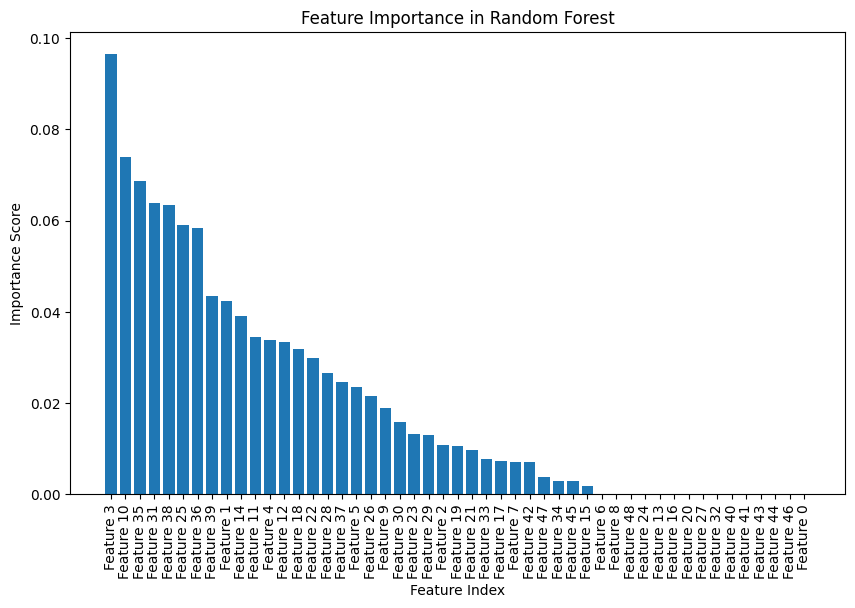

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importance scores
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [f"Feature {i}" for i in indices], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()